In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, classification_report
import matplotlib.pyplot as plt


In [2]:
df = pd.read_parquet("../ETL/data/engineered/final_data_2025Q1.parquet")
df.head()

,side,log_dollar_value,role,is_10b5_1,log_size_vs_cap,label_up_market
3,sell,15.441086,OFFICER,0,-9.087956,1
4,sell,14.496378,DIRECTOR,0,-10.032665,1
5,buy,13.401964,OFFICER,0,-9.559271,1
6,sell,14.673079,OFFICER,1,-10.128313,0
7,sell,11.586464,DIRECTOR,1,-13.214937,0


In [3]:
print(df[df.isna().any(axis=1)]) # shows NaN values in data frame if it exists

Empty DataFrame
Columns: [side, log_dollar_value, role, is_10b5_1, log_size_vs_cap, label_up_market]
Index: []


In [4]:
# Print data types of each column using row 1
print("Data types of each column:")
print(df.dtypes)

Data types of each column:
side                 object
log_dollar_value    float64
role                 object
is_10b5_1             int64
log_size_vs_cap     float64
label_up_market       int64
dtype: object


In [5]:
# Calculate percentage of 1 and 0 values for label_up_market
percentages = df['label_up_market'].value_counts(normalize=True) * 100
print(percentages)

label_up_market
0    60.685348
1    39.314652
Name: proportion, dtype: float64


In [6]:
attr = df.drop(columns=[ 'label_up_market'])
target = df['label_up_market']
attr.head()


# One-hot encode categorical columns
attr = pd.get_dummies(attr, columns=['side', 'role'], drop_first=False)
attr.head()

,log_dollar_value,is_10b5_1,log_size_vs_cap,side_buy,side_sell,role_DIRECTOR,role_OFFICER,role_OTHER,role_TENPERCENTOWNER
3,15.441086,0,-9.087956,False,True,False,True,False,False
4,14.496378,0,-10.032665,False,True,True,False,False,False
5,13.401964,0,-9.559271,True,False,False,True,False,False
6,14.673079,1,-10.128313,False,True,False,True,False,False
7,11.586464,1,-13.214937,False,True,True,False,False,False


In [7]:
print("Data types of each column of attr:")
print(attr.dtypes)

Data types of each column of attr:
log_dollar_value        float64
is_10b5_1                 int64
log_size_vs_cap         float64
side_buy                   bool
side_sell                  bool
role_DIRECTOR              bool
role_OFFICER               bool
role_OTHER                 bool
role_TENPERCENTOWNER       bool
dtype: object


In [8]:
# Split data for traning and test
attr_train, attr_test, target_train,target_test  = train_test_split(attr, target,test_size = 0.3, random_state =82 , shuffle = True)

# Create and train the DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy', max_depth=5,max_leaf_nodes=10, random_state=82)
model.fit(attr_train, target_train)

# Make predictions
target_pred = model.predict(attr_test)

# Evaluate the model
accuracy = accuracy_score(target_test, target_pred)
print(f'Accuracy: {accuracy:.4f}')
print(f"Precision (for class 1): {precision_score(target_test, target_pred)}")

print('Classification Report')
print(classification_report(target_test, target_pred))



Accuracy: 0.6181
Precision (for class 1): 0.5210084033613446
Classification Report
              precision    recall  f1-score   support

           0       0.65      0.79      0.71      1079
           1       0.52      0.35      0.42       699

    accuracy                           0.62      1778
   macro avg       0.59      0.57      0.57      1778
weighted avg       0.60      0.62      0.60      1778



# Performance
- Accuracy: 0.618
- Precision (class 1): 0.521


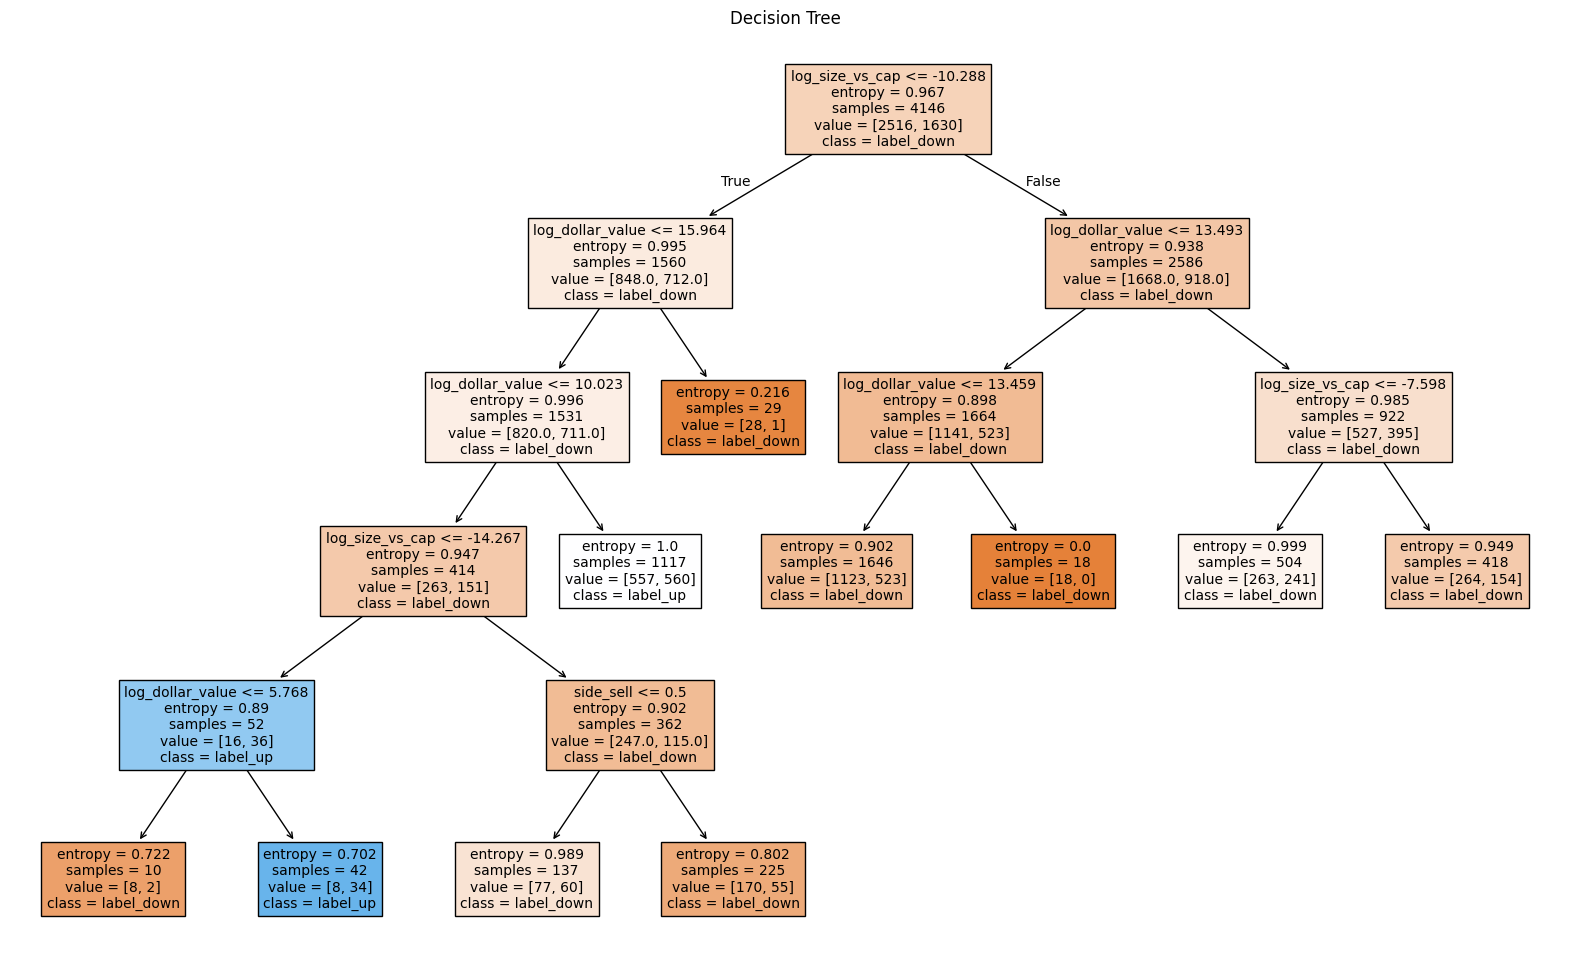

In [9]:
plt.figure(figsize=(20, 12))
plot_tree(model, 
         feature_names=attr.columns,
         class_names=['label_down', 'label_up'], 
         filled=True, 
         fontsize=10)
plt.title("Decision Tree")
plt.show()

In [10]:
# Show feature importance
feature_importance = pd.DataFrame({
    'Feature': attr.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                Feature  Importance
0      log_dollar_value    0.540730
2       log_size_vs_cap    0.388412
4             side_sell    0.070859
1             is_10b5_1    0.000000
3              side_buy    0.000000
5         role_DIRECTOR    0.000000
6          role_OFFICER    0.000000
7            role_OTHER    0.000000
8  role_TENPERCENTOWNER    0.000000
